In [1]:
# packages used
import pandas as pd
import numpy as np
from sklearn import tree
#from sklearn.ensemble import BaggingClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Load the data
data_dir = 'Data/'
Stores = pd.read_csv(data_dir + 'AllStoresKansas.csv', dtype = str)
StoreType = pd.read_csv(data_dir + 'NonLowPointStoresKansas.csv', dtype = str)

In [3]:
Stores.head()

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG
0,101403888,SEDGWICK,OFF,LIQUOR,CONVENTIONAL LIQUOR,Y,Y
1,100091604,SALINE,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N
2,200697901,SEDGWICK,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N
3,100091143,HARPER,OFF,GROCERY,SUPERMARKET-CONVENTIONAL,Y,N
4,107381463,DOUGLAS,OFF,GROCERY,SUPERMARKET-NATURAL/GOURMET FOODS,Y,N


In [4]:
StoreType.head()

,RTL_STORE_CD,BEERTYPE
0,201919318,NonLowPoint
1,205526360,NonLowPoint
2,100765511,NonLowPoint
3,101868466,NonLowPoint
4,103714116,NonLowPoint


In [5]:
FullData = pd.merge(Stores, StoreType, on="RTL_STORE_CD", how="left")

In [6]:
FullData.loc[FullData['BEERTYPE'].isnull(),"BEERTYPE"] = "LowPoint"

In [7]:
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_FIPS_COUNTY_DSC'],prefix='COUNTY')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_PREMISE_TYPE_CD'],prefix='PREMISE')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_CHANNEL_DSC'],prefix='CHANNEL')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_SUBCHANNEL_DSC'],prefix='SUBCHANNEL')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_BEER_FLAG'],prefix='BEER_LICENSE')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_LIQUOR_FLG'],prefix='LIQUOR_LICENSE')], axis=1)
FullData.head()

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,COUNTY_ALLEN,COUNTY_ANDERSON,...,SUBCHANNEL_SUPERMARKET-NATURAL/GOURMET FOODS,SUBCHANNEL_THEATER,SUBCHANNEL_UNKNOWN,SUBCHANNEL_WINE SPECIALTY STORE,BEER_LICENSE_N,BEER_LICENSE_U,BEER_LICENSE_Y,LIQUOR_LICENSE_N,LIQUOR_LICENSE_U,LIQUOR_LICENSE_Y
0,101403888,SEDGWICK,OFF,LIQUOR,CONVENTIONAL LIQUOR,Y,Y,NonLowPoint,0,0,...,0,0,0,0,0,0,1,0,0,1
1,100091604,SALINE,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,0,0,...,0,0,0,0,0,0,1,1,0,0
2,200697901,SEDGWICK,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,0,0,...,0,0,0,0,0,0,1,1,0,0
3,100091143,HARPER,OFF,GROCERY,SUPERMARKET-CONVENTIONAL,Y,N,LowPoint,0,0,...,0,0,0,0,0,0,1,1,0,0
4,107381463,DOUGLAS,OFF,GROCERY,SUPERMARKET-NATURAL/GOURMET FOODS,Y,N,LowPoint,0,0,...,1,0,0,0,0,0,1,1,0,0


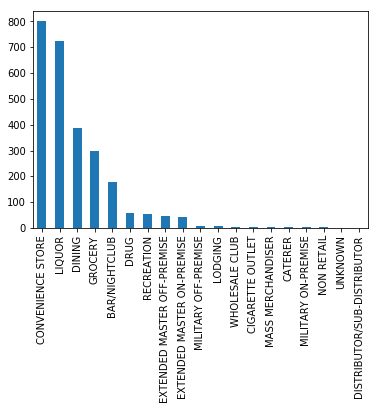

In [8]:
# Total Number Counts of Stores by Trade Channel
Channel = FullData.loc[:,'RTL_CHANNEL_DSC']
Channel = Channel.value_counts()
Channel.plot.bar()

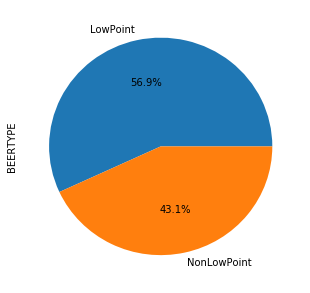

In [9]:
# Percentage of Stores which sell NonLowPoint(>3.2% ABW) Beer vs LowPoint(<3.2% ABW)  Beer
Type = FullData.loc[:,'BEERTYPE']
Type = Type.value_counts()
Type.plot.pie(autopct='%1.1f%%', figsize=(5,5))

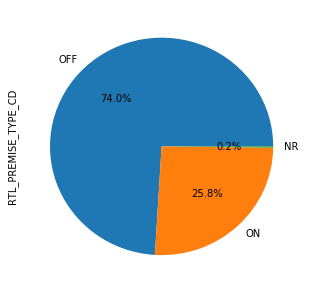

In [10]:
# Percentage of Stores which Off Premise vs On Premise
Premise = FullData.loc[:,'RTL_PREMISE_TYPE_CD']
Premise = Premise.value_counts()
Premise.plot.pie(autopct='%1.1f%%', figsize=(5,5))

In [11]:
# Count number of stores per channel
LowPointChannel =FullData.loc[FullData["BEERTYPE"]=="LowPoint",'RTL_CHANNEL_DSC'].value_counts()
NonLowPointChannel =FullData.loc[FullData["BEERTYPE"]=="NonLowPoint",'RTL_CHANNEL_DSC'].value_counts()

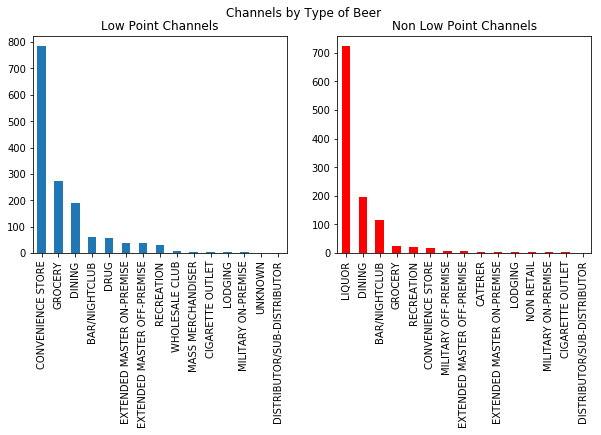

In [12]:
#Plot Channels by Type of Beer
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

LowPointChannel.plot(ax=axes[0], kind='bar'); axes[0].set_title('Low Point Channels')
NonLowPointChannel.plot(ax=axes[1], kind='bar', color = 'r'); axes[1].set_title('Non Low Point Channels')
fig.suptitle('Channels by Type of Beer')
#plt.tight_layout()

In [13]:
### Prepare Data

In [14]:
# prepare data to fit model
X_labels = [c for c in FullData.columns if c not in ['RTL_STORE_CD','BEERTYPE','RTL_FIPS_COUNTY_DSC','RTL_PREMISE_TYPE_CD','RTL_CHANNEL_DSC','RTL_SUBCHANNEL_DSC','RTL_BEER_FLAG',"RTL_LIQUOR_FLG"]]
X = FullData.loc[:,X_labels]
Y = FullData['BEERTYPE']

# split data to training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [15]:
clf = tree.DecisionTreeClassifier(min_samples_split = 10)
clf = clf.fit(X_train,Y_train)

In [16]:
clf.score(X_test, Y_test)

0.94876660341555974

In [17]:
#try to find the best tree depth with min split.

#tree depth

#Fit a classification tree to the data with various values of the parameters max_depth and min_samples_leaf, 
#Report the cross-validation errors associated with different values of these parameters.

# change the parameter depth and compute test error
TreeDepth = range(1,21)
MinLeaf = range(1,41)
results = []
for d in TreeDepth:
    for l in MinLeaf:
        clf = tree.DecisionTreeClassifier(max_depth=d, min_samples_leaf=l,random_state=0)
        clf = clf.fit(X,Y)    
        scores = cross_val_score(clf, X, Y, cv=5)
        results.append((d,l,scores.mean(), scores.std()))
    
df_tree_accuracy = pd.DataFrame(data=results,columns=['depth','min_sample_leaf','mean','std'])
df_tree_accuracy['depth_leaf']= df_tree_accuracy['depth'].astype(str)+"_"+df_tree_accuracy['min_sample_leaf'].astype(str)

#sort the dataframe
df_tree_accuracy = df_tree_accuracy.sort_values(['mean'], ascending = False)
df_tree_accuracy.head()

,depth,min_sample_leaf,mean,std,depth_leaf
404,11,5,0.950285,0.007333,11_5
400,11,1,0.949904,0.008198,11_1
361,10,2,0.949527,0.008526,10_2
405,11,6,0.949526,0.007053,11_6
724,19,5,0.949147,0.006929,19_5


# Result

In [18]:
#the result: with the best tree depth and accuracy
best_depth = df_tree_accuracy[df_tree_accuracy['mean'] == max(df_tree_accuracy['mean'])]
best_depth = int(best_depth['depth'])
print('the best depth is:', best_depth, 'with accuracy:',round(max(df_tree_accuracy['mean'])*100, 3), '%')

the best depth is: 11 with accuracy: 95.029 %


In [19]:
#check the errors:

#create a new data frame to store the prediction result. 
result_df = FullData.loc[:, 'RTL_STORE_CD': 'BEERTYPE']
result_df['PRED_RESULT'] = clf.predict(X)
result_df.head()

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,PRED_RESULT
0,101403888,SEDGWICK,OFF,LIQUOR,CONVENTIONAL LIQUOR,Y,Y,NonLowPoint,NonLowPoint
1,100091604,SALINE,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,LowPoint
2,200697901,SEDGWICK,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,LowPoint
3,100091143,HARPER,OFF,GROCERY,SUPERMARKET-CONVENTIONAL,Y,N,LowPoint,LowPoint
4,107381463,DOUGLAS,OFF,GROCERY,SUPERMARKET-NATURAL/GOURMET FOODS,Y,N,LowPoint,LowPoint


In [20]:
#check how many stores are predicted wrong; which are they; what characters do they have
error_index_list = []
for index in range(len(result_df)):
    if result_df.ix[index , 'BEERTYPE'] != result_df.ix[index , 'PRED_RESULT']:
        error_index_list.append(index)
print('there are', len(error_index_list), 'errors in the prediction')

there are 184 errors in the prediction


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


In [21]:
#check the error predictions
error_df = result_df.ix[error_index_list, ]
false_NonLowPoint = error_df.loc[error_df['BEERTYPE'] == 'LowPoint']
print('there are', len(false_NonLowPoint), errors )
false_NonLowPoint.head()

NameError: name 'errors' is not defined

In [ ]:
# Percentage of Stores which sell NonLowPoint(>3.2% ABW) Beer vs LowPoint(<3.2% ABW)  Beer
Type = FullData.loc[:,'BEERTYPE']
Type = Type.value_counts()
Type.plot.pie(autopct='%1.1f%%', figsize=(5,5))

In [ ]:
false_LowPoint = error_df.loc[error_df['BEERTYPE'] == 'NonLowPoint']
false_LowPoint

In [ ]:
#feature importance

#all the features with their importance scores.
feature_score = pd.Series(data=clf.feature_importances_, index=X.columns).sort_values(ascending = False)

#only show the features that have scores greater than 0
feature_score[feature_score > 0]